<a href="https://colab.research.google.com/github/rawatpremsingh999/tensorflow-coursera/blob/master/coursera_4210.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def plot_series(time, series, format = '-', start = 0, end = None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel('Time')
  plt.ylabel('Value')
  plt.grid(True)

def trend(time, slope = 0):
  return slope * time


def seasonal_pattern(season_time):
  """Just an arbitrary pattern, you can change it if you wish"""
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
                  1/np.exp(3 * season_time))
  

def seasonality(time, period, amplitude = 1, phase=0):
  """Repeats the same pattern at each period"""
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level = 1, seed = None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level


time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed = 42)


# split the dataset into training and validation
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]


window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift = 1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

Simple Linear regression

In [8]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

model.compile(loss="mse", optimizer= tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset, epochs=100, verbose=2)

Epoch 1/100
31/31 - 0s - loss: 566.9910
Epoch 2/100
31/31 - 0s - loss: 121.7716
Epoch 3/100
31/31 - 0s - loss: 97.4111
Epoch 4/100
31/31 - 0s - loss: 87.5981
Epoch 5/100
31/31 - 0s - loss: 84.5246
Epoch 6/100
31/31 - 0s - loss: 79.6898
Epoch 7/100
31/31 - 0s - loss: 77.3923
Epoch 8/100
31/31 - 0s - loss: 74.4507
Epoch 9/100
31/31 - 0s - loss: 73.8773
Epoch 10/100
31/31 - 0s - loss: 73.2078
Epoch 11/100
31/31 - 0s - loss: 70.3234
Epoch 12/100
31/31 - 0s - loss: 69.1196
Epoch 13/100
31/31 - 0s - loss: 68.6088
Epoch 14/100
31/31 - 0s - loss: 67.3557
Epoch 15/100
31/31 - 0s - loss: 65.5311
Epoch 16/100
31/31 - 0s - loss: 64.8698
Epoch 17/100
31/31 - 0s - loss: 64.9632
Epoch 18/100
31/31 - 0s - loss: 63.8818
Epoch 19/100
31/31 - 0s - loss: 62.6809
Epoch 20/100
31/31 - 0s - loss: 61.5773
Epoch 21/100
31/31 - 0s - loss: 61.2850
Epoch 22/100
31/31 - 0s - loss: 60.1259
Epoch 23/100
31/31 - 0s - loss: 59.2753
Epoch 24/100
31/31 - 0s - loss: 58.5961
Epoch 25/100
31/31 - 0s - loss: 58.7122
Epoch 2

In [9]:
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.0164391 ],
       [-0.05288021],
       [ 0.08140948],
       [-0.0119872 ],
       [ 0.01423705],
       [-0.06333231],
       [ 0.02360073],
       [ 0.0252896 ],
       [ 0.01821168],
       [ 0.01082278],
       [-0.08370972],
       [ 0.06955137],
       [-0.07305589],
       [ 0.06847141],
       [-0.02313358],
       [ 0.11749376],
       [-0.05477423],
       [ 0.24449213],
       [ 0.24208556],
       [ 0.4424329 ]], dtype=float32), array([0.01255375], dtype=float32)]


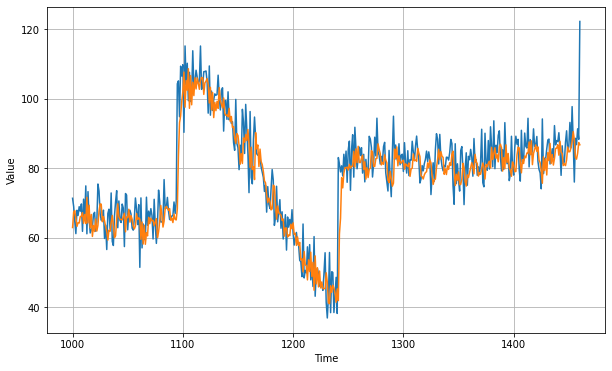

In [14]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [15]:
print("MSE: ",tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print("MAE: ",tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

MSE:  47.590797
MAE:  5.095446


In [33]:
np.array(forecast)[:,0,0]

array([ 62.915127,  67.39429 ,  67.77273 ,  65.46816 ,  63.249645,
        64.30661 ,  64.2132  ,  66.07191 ,  66.18308 ,  67.21106 ,
        64.13217 ,  66.65764 ,  64.05828 ,  71.63223 ,  64.23359 ,
        69.33784 ,  62.825283,  66.68089 ,  60.347572,  63.51341 ,
        61.75161 ,  65.3813  ,  61.89493 ,  63.51268 ,  67.67843 ,
        69.73738 ,  69.63788 ,  64.58777 ,  66.069786,  64.807915,
        63.133396,  61.678047,  59.30149 ,  62.139103,  61.82528 ,
        64.287224,  66.3991  ,  63.695778,  59.999043,  60.515434,
        65.410225,  69.76795 ,  65.96787 ,  65.33201 ,  65.244675,
        65.10889 ,  66.03715 ,  67.044235,  61.68147 ,  65.99483 ,
        65.76408 ,  68.17985 ,  64.48193 ,  66.34077 ,  65.26968 ,
        63.29174 ,  62.501938,  63.33132 ,  66.95787 ,  65.2408  ,
        65.70006 ,  65.33543 ,  59.51453 ,  64.50169 ,  58.154785,
        63.59073 ,  58.081562,  61.445072,  60.51084 ,  65.847374,
        64.0161  ,  65.58469 ,  64.87661 ,  64.96804 ,  63.404